# A Convolutional Neural Network to Classify the CIFAR dataset

[Prashant Brahmbhatt](www.github.com/hashbanger)

References:  
- [Deep-Diver Github](https://github.com/deep-diver/)  
- [CIFAR-10 official Documentation](https://www.cs.toronto.edu/~kriz/cifar.html)

___

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [01:32, 1.84MB/s]                           


The CIFAR-10 dataset consists of 10 object classes dogs, cats, aeroplanes, automobile, deer, horse, ship, truck, frog, bird.  
We will require the labels to be one-hot encoded and the images require to be normalized.

In [0]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

The data files.
The data archive would be extracted in 6 data files named as 
    - data_batch_i (1,2,...5)
    - test_batch

## Knowing the data

The dataset contains coloured images of dimensions 32 x 32.  
As the documentation states that the data files contains numpy arrays of (10000 * 3072) in row major order  
32 height x 32 width x 3 channels RGB = 3072  
There are 10000 images per data_batch = 50000 train images  
10000 test images.  
The first 1024 channels are for red channel ,next for green channel and then blue.

The provided dimensions are not suitable to be fetched into the tensorflow so we will need to shape the data as the **tf.nn.conv2d()** requires which is either  

**[batch , height , width , num_of_channels]**  or an alternative form could be  

**[batch , num_of_channels , height , width]**

## The Labels

The original order of the data labels are:  

**0 airplane 										
1 automobile 										
2 bird 										
3 cat 										
4 deer 										
5 dog 										
6 frog 										
7 horse 										
8 ship 										
9 truck**

In [0]:
def load_label_names():
    return['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Reshaping the data

We will firstly use the **numpy.reshape()** to shape our images and using the **np.traspose()** function.  
The reshaping will be done in two steps:  
- First we will convert the row vector 3072  into 3 x 1024, as per the channel.  
- Secondly, we will convert it to 3 x 32 x 32 by dividing the tensor resulting from the first reshape by 32 where 32 is the width of the image because of the row major order.

The reshape function will be called with parameters, (10000, 3, 32, 32).  

Now, the data is represented as **(num_channel , width , height)** form. But tensorflow and matplotlib expect a different shape. They expect **(width , height , num_channel)** instead. We need to swap the order using the transpose.  

The transpose function can take a list of axes, and each value specifies where it wants to move around. For example, calling transpose with argument **(1, 2, 0)** in an numpy array of **(num_channel, width, height)** will return a new numpy array of **(width, height, num_channel)**.

In [0]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
 #Here we can use len(batch['data'] in place of -1 but -1 automatically considers the size of the batch
    
    labels = batch['labels']
        
    return features, labels

### Data Exploring

The below code cells are used to know about the data and its stats.

In [0]:
def display_stats(cifar_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not 0 <= sample_id < len(features):
        print("{} samples in batch {} .{} is out of range".format(len(features), batch_id, sample_id))
        return None
    
    print("\nBatch {} Stats\n".format(batch_id))
    print("Number of samples: {}\n".format(len(features)))
    label_names = load_label_names()
    label_counts =  dict(zip(*np.unique(labels, return_counts = True))) 
    #return_count will return number of the counts and a second tuple will be returned with positional counts
    #the starred expression here will automatically map the two returned tuples as arguments of zip
    #for starred expression docs refer (https://docs.python.org/dev/reference/expressions.html#calls)
    
    for key, value in label_counts.items(): #.items() returns a tuple of the key value pairs
        print('Counts of {} {} are {}'.format(key, label_names[key], value))
        
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('Example of image {}'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape:{}'.format(sample_image.shape))
    print('Label - Label _id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)    
    


Batch 2 Stats

Number of samples: 10000

Counts of 0 airplane are 984
Counts of 1 automobile are 1007
Counts of 2 bird are 1010
Counts of 3 cat are 995
Counts of 4 deer are 1010
Counts of 5 dog are 988
Counts of 6 frog are 1008
Counts of 7 horse are 1026
Counts of 8 ship are 987
Counts of 9 truck are 985
Example of image 6000
Image - Min Value: 5 Max Value: 182
Image - Shape:(32, 32, 3)
Label - Label _id: 7 Name: horse


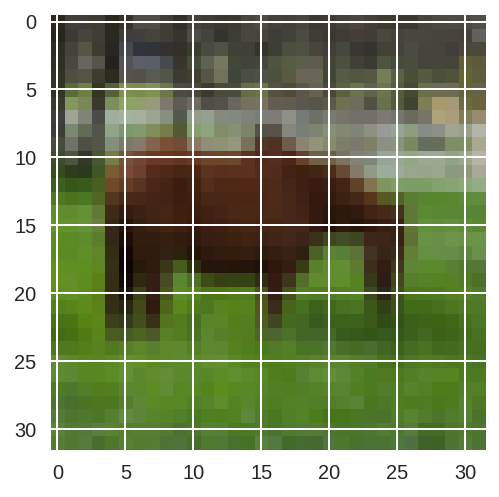

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

batch_id = 2
sample_id = 6000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocessing The Inputs

### Normalization

We have to make all the input values for al the images between 0 and 1.  
We use the Min-Max Scaling.  

#### Min Max Normalization
Minmax normalization is a normalization strategy which linearly transforms x to y   
## $$y = (x-min)/(max-min)$$  
Where min and max are the minimum and maximum values in X, where X is the set of observed values of x.  
It can be easily seen that when x=min, then y=0, and
When $x=max$, then $y=1$.
This means, the minimum value in X is mapped to 0 and the maximum value in X is mapped to 1. So, the entire range of values of X from min to max are mapped to the range 0 to 1.

Why normalization should be performed is somewhat related to activation function.  
Sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value easily reaches the max value 1. Similarily, when the input value is somewhat small, the output value easily reaches the max value 0.
ReLU activation function takes an input value and outputs a new value ranging from 0 to infinity. When the input value is somewhat large, the output value increases linearly. However, when the input value is somewhat small, the output value easily reaches the max value 0.  

The images are in an input range from 0 to 255 so no normalization is likely to result in 1 most of the times which would not be appropriate. So we define a normalize function.

In [0]:
def normalize(x):
    "input the numpy array to be normalized"
    min_ = np.min(x) #the conventional min() would not work here
    max_ = np.max(x)
    y = (x - min_)/(max_ - min_ )
    return y

Let's see if our function works correct

In [10]:
normalize( np.array([[[3,3,3],[1,2,3],[4,5,6]]]) )

array([[[0.4, 0.4, 0.4],
        [0. , 0.2, 0.4],
        [0.6, 0.8, 1. ]]])

Looks like the function is working well with our sample 3D array.

### One hot encoding

Since for each image the model would require to match its output probabilities for each of the 10 classes with the ground truth. But our label is only a single value so we have to modify it in a 1D vector of size 10.

Example:** 3 ---one-hot---->  [0,0,0,1,0,0,0,0,0,0] **

In [0]:
def one_hot_encode(x):
    "Takes numpy array and One Hot Encodes"
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
        
    return encoded

Now we use all the above defined functions and preprocess all the input data and save it as a file.  
We will also use 90% inputs from each batch during the training ad the rest of the 10% will be used as the validation set.

In [0]:
#Not working
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

    
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []
    
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        #we use the 10% of the input of each batch to be reserved for validation
        #So we preprocess all the training data and normalize the validation all stacked together
        index_of_validation = int(len(features) * 0.1)
        
        #Preprocess 90%
        # noramlize
        # one hot encode
        # save it as new file
        # save file per batch
        _preprocess_and_save(normalize, one_hot_encode, features[:-index_of_validation], 
                           labels[:-index_of_validation], 'preprocess_batch_'+ str(batch_i)+ '.p')
        
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(features[-index_of_validation:])
        
    #preprocess all the stacked validation set
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

   
    #load the test set
    with open(cifar10_dataset_folder_path+'/test_batch', mode = 'rb') as file:
        batch = pickle.load(file,  encoding= 'latin1')
        
    #reshaping the test set
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']
    
    #preprocess and save all the test set
    _preprocess_and_save(normalize, one_hot_encode, np.array(test_features), np.array(test_labels)
                        ,'preprocess_training.p')
        
        

In [0]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        #we use the 10% of the input of each batch to be reserved for validation
        #So we preprocess all the training data and normalize the validation all stacked together
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        #Preprocess 90%
        # noramlize
        # one hot encode
        # save it as new file
        # save file per batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    #preprocess all the stacked validation set
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # reshaping the test set
    test_features = batch['data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    #preprocess and save all the test set
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [0]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

___________________

In [0]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode = 'rb'))

## Building the Network

In [0]:
#Removing the previous weights, biases, inputs from memory
tf.reset_default_graph()

#Input
x = tf.placeholder(tf.float32, shape = (None, 32, 32, 3), name = 'input_x')
y = tf.placeholder(tf.float32, shape = (None, 10), name = 'output_y')
keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')

### The Network Layout  

The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

- Convolution Layer of dimension 3 x 3 x 64  (where 64 being the number of filters)  
ReLU activation function  
Max Pooling by 2    
Batch Normalization   

    
- Convolution Layer of dimension 3 x 3 x 128    
ReLU activation function    
Max Pooling by 2    
Batch Normalization
    
    
- Convolution Layer of dimension 3 x 3 x 256  
ReLU activation function  
Max Pooling by 2    
Batch Normalization


- Convolution Layer of dimension 3 x 3 x 512  
ReLU activation function  
Max Pooling by 2    
Batch Normalization


- Flattening output of the last convolutional layer.


- Full connection of 128 units  
Dropout  
Batch Normalization  


- Full connection of 256 units  
Dropout  
Batch Normalization  


- Full connection of 512 units  
Dropout  
Batch Normalization  


- Full connection of 1024 units  
Dropout  
Batch Normalization  


- Full connection of 10 units (number of image classes)


References to [batch normalization](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c)

In [0]:
def conv_net(x, keep_prob):
    
    conv1_filter = tf.Variable(tf.truncated_normal(shape = [3, 3, 3, 64], mean= 0, stddev= 0.08))
    conv1 = tf.nn.conv2d(x, conv1_filter, [1, 1, 1, 1], padding= 'SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding= 'SAME')
#    conv1_bn = tf.nn.batch_normalization(conv1_pool)
    
    conv2_filter = tf.Variable(tf.truncated_normal(shape = [3, 3, 64, 128], mean= 0, stddev= 0.08))
    conv2 = tf.nn.conv2d(conv1_pool, conv2_filter, [1, 1, 1, 1], padding= 'SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding= 'SAME')
#    conv2_bn = tf.nn.batch_normalization(conv2_pool)
    
    conv3_filter = tf.Variable(tf.truncated_normal(shape = [5, 5, 128, 256], mean= 0, stddev= 0.08))
    conv3 = tf.nn.conv2d(conv2_pool, conv3_filter, [1, 1, 1, 1], padding= 'SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding= 'SAME')
#    conv3_bn = tf.nn.batch_normalization(conv3_pool)
    
    conv4_filter = tf.Variable(tf.truncated_normal(shape = [5, 5, 256, 512], mean= 0, stddev= 0.08))
    conv4 = tf.nn.conv2d(conv3_pool, conv4_filter, [1, 1, 1, 1], padding= 'SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding= 'SAME')
#    conv4_bn = tf.nn.batch_normalization(conv4_pool)  
    
    flat = tf.contrib.layers.flatten(conv4_pool)
    
    full1 = tf.contrib.layers.fully_connected(inputs = flat, num_outputs = 128, activation_fn = tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
#    full1 = tf.layers.batch_normalization(full1)
    
    full2 = tf.contrib.layers.fully_connected(inputs = full1, num_outputs = 256, activation_fn = tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
#    full2 = tf.layers.batch_normalization(full2)
    
    full3 = tf.contrib.layers.fully_connected(inputs = full2, num_outputs = 512, activation_fn = tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
#    full3 = tf.layers.batch_normalization(full3)
    
    full4 = tf.contrib.layers.fully_connected(inputs = full3, num_outputs = 1024, activation_fn = tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
#    full4 = tf.layers.batch_normalization(full4)
    
    out = tf.contrib.layers.fully_connected(inputs = full4, num_outputs = 10, activation_fn = None)
    return out

## Hyperparameters

In [0]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

## Cost Optimization and Loss Functions

In [0]:
logits = conv_net(x, keep_prob)
model = tf.identity(logits, name = 'logits')

#Loss function and Optimization
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits= logits, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(cost)

#Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name = 'accuracy')

## Training the Network

### Single Optimization

In [0]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict = {x: feature_batch, y: label_batch, keep_prob: keep_probability})

### Show Stats

In [0]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, feed_dict = {x: feature_batch, y:label_batch, keep_prob: 1})
    
    valid_acc = sess.run(accuracy, feed_dict = {x: valid_features, y: valid_labels, keep_prob: 1})
    
    print('Loss: {:10.4f} Validation Accuracy:{:.6f}'.format(loss, valid_acc))

### Fully Train the Model

In [0]:
def batch_feature_labels(features, labels, batch_size):
    """Split features and labels into batches"""
    for start in range(0, len(features), batch_size):
        end = min(start +batch_size , len(features))
        yield features[start:end], labels[start:end]
    
def load_preprocess_training_batch(batch_id, batch_size):
    """Load the Preprocessed Training data and return them in batches of <batch_size> or less"""
    filename = 'preprocess_batch_'+ str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode = 'rb'))
    
    # Return the training data in batches of size <batch_size> or less
    return batch_feature_labels(features, labels, batch_size)

In [60]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2636 Validation Accuracy:0.152000
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.9547 Validation Accuracy:0.183600
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.7651 Validation Accuracy:0.199800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.7986 Validation Accuracy:0.274600
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.6305 Validation Accuracy:0.262000
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8135 Validation Accuracy:0.253200
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.7203 Validation Accuracy:0.272800
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.5422 Validation Accuracy:0.336200
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.5171 Validation Accuracy:0.386400
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.4735 Validation Accuracy:0.340000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.3993 Validation Accuracy:0.440000
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.2263 Validation Accuracy:0.481400
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.0714 Validation Accuracy:0.472600
Epoch  3, CIF

In [61]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

## de nada!